In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from ipywidgets import interact, interactive, fixed#, interact_manual
import ipywidgets as widgets
from IPython.display import display

In [3]:
from samwich.dataloaders import XarrayData
from samwich.waketrackers import track

In [4]:
from study import V27, neutral
case = neutral(casedir='WAKEBENCH-NREL_DEBNATH_LES/neutral',
               prefix='NREL_DEBNATH_LES_20190325',
               turbine=V27)

In [5]:
downD =3.0
infile = 'wake_centers_3D--manual_ID_5min.csv'
# downD = 6.0
# infile = 'wake_centers_6D--manual_ID_5min.csv'

In [6]:
# load wake
data = XarrayData(case.get_wake_datafile(downD),
                  uvar='U',vvar='V',wvar='W',
                  trim_time=case.trim_time(downD))
x,y,z,u = data.sliceI()
print('plane at',downD,'downstream: x=',np.mean(x))
Ntimes,Ny,Nz,Ncomp = u.shape
print(Ntimes,Ny,Nz)

Selected datafile: WAKEBENCH-NREL_DEBNATH_LES/neutral/NREL_DEBNATH_LES_20190325_uvw_3D.nc
Calculated offset: 17
Slicing data at i=0 x=81.0
plane at 3.0 downstream: x= 81.0
1587 162 162


In [7]:
# form grid
y1 = (y[1:,0] + y[:-1,0]) / 2  # midpoints
z1 = (z[0,1:] + z[0,:-1]) / 2
y0 = [2*y[0,0] - y1[0]] # y0 - (y1 - y0)
z0 = [2*z[0,0] - z1[0]] # y0 - (y1 - y0)
yn = [2*y[-1,0] - y1[-1]] # yn + (yn - ym)
zn = [2*z[0,-1] - z1[-1]] # yn + (yn - ym)
y1 = np.concatenate((y0,y1,yn))
z1 = np.concatenate((z0,z1,zn))
#print(y1)
#print(z1)
yy,zz = np.meshgrid(y1,z1,indexing='ij')

In [8]:
# read previous wake (if it exists)
yw,zw = np.empty(Ntimes),np.empty(Ntimes)
try:
    existing_trajectory = np.loadtxt(infile)
except IOError:
    yw[:] = np.nan
    zw[:] = np.nan
else:
    Nread = len(existing_trajectory)
    yw[:Nread] = existing_trajectory[:,0]
    zw[:Nread] = existing_trajectory[:,1]
    yw[Nread:] = np.nan
    zw[Nread:] = np.nan

In [9]:
# remove shear
wo = track((x,y,z,u), method='Gaussian')
wo.remove_shear(wind_profile=case.get_inflow(downD))

Selected Tracker: Gaussian

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 81.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1587

...finished initializing WakeTracker

...finished initializing Gaussian 

  subtracting out time-varying profile


<IPython.core.display.Javascript object>


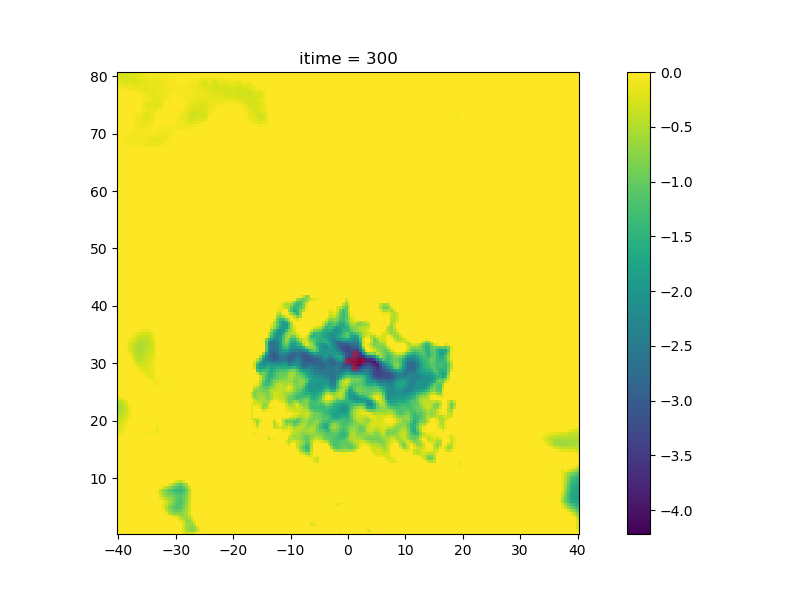

interactive(children=(IntSlider(value=0, description='itime', max=1586), Output()), _dom_classes=('widget-inte…

Button(description='save location', disabled=True, style=ButtonStyle())

In [12]:
# setup plot
fig,ax = plt.subplots(figsize=(8,6))
cm = ax.pcolormesh(yy,zz,wo.u[0,:,:],vmin=-3,vmax=3)
ctr, = ax.plot([],[],'r+',markersize=14,markeredgewidth=4,alpha=0.4)
cbar = fig.colorbar(cm,ax=ax)
title = ax.set_title('')
ax.axis('scaled')

global ysel,zsel
ysel, zsel = None, None    

def update_plot(itime):
    savebutton.disabled = True
    cm.set_array(wo.u[itime,:,:].ravel())
    cm.set_clim(np.min(wo.u[itime,:,:]), 0)
    if np.isfinite(yw[itime]) and np.isfinite(zw[itime]):
        ctr.set_data(yw[itime],zw[itime])
    else:
        ctr.set_data([],[])
    title.set_text('itime = {:g}'.format(itime))
    
    # define mouse callback
    def on_click(event):
        global ysel,zsel
        if event.inaxes != ax:
            return
        if event.button == 1:
            ysel,zsel = event.xdata, event.ydata
            title.set_text('itime = {:g}:  {:g}, {:g} (not saved)'.format(itime, ysel, zsel))
            ctr.set_data(ysel,zsel)
        elif event.button == 3:
            ysel,zsel = np.nan, np.nan
            title.set_text('itime = {:g}, cleared (not saved)'.format(itime))
            ctr.set_data([],[])
        savebutton.disabled = False
    fig.canvas.mpl_connect('button_press_event', on_click)
    
# setup widgets
timeselect = widgets.IntSlider(min=0, max=Ntimes-1, step=1, value=0)
savebutton = widgets.Button(description='save location', disabled=True)    
interact(update_plot, itime=timeselect)
display(savebutton)

# handle button click
def save_selected_point(b):
    global ysel,zsel
    itime = timeselect.value
    yw[itime] = ysel
    zw[itime] = zsel
    if (ysel is np.nan) or (zsel is np.nan):
        title.set_text('itime = {:g}, cleared'.format(itime, ysel, zsel))
    else:
        title.set_text('itime = {:g}:  {:g}, {:g}'.format(itime, ysel, zsel))
    ysel,zsel = None, None
    b.disabled = True
savebutton.on_click(save_selected_point)